In [1]:
!pip -q install xarray-spatial shap git+https://github.com/s-kganz/xbatcher.git@patch_filter_resample
# Make sure git install worked
import xbatcher
print(xbatcher.__version__)

0.1.dev236+g2e721fc


In [2]:
import xarray as xr
import xrspatial
import rioxarray
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap
import os

try:
    import util
except ImportError:
    if 'notebooks' in os.getcwd():
        os.chdir("..")
finally:
    import util

/home/jovyan/ForestLST/util/__init__.py:13: UserWarning: ImportError on util.training: No module named 'torch'. Module util.training will not be loaded.
  warnings.warn(f"ImportError on util.training: {str(e)}. Module util.training will not be loaded.")


Prepare data. Here we are trying to replicate the RF described in [Preisler et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0378112717304772) so we need to do some feature engineering to match their work.

In [3]:
# Prepare data - since we are working with tabular data here we convert
# to a dataframe.
ds = xr.load_dataset("data_working/westmort_1km.nc")
ds

<xarray.Dataset> Size: 4GB
Dimensions:      (y: 2608, x: 2360, time: 27)
Coordinates:
  * x            (x) float64 19kB -1.39e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y            (y) float64 21kB 6.28e+06 6.279e+06 ... 3.674e+06 3.673e+06
  * time         (time) int64 216B 1997 1998 1999 2000 ... 2020 2021 2022 2023
Data variables: (12/16)
    elev         (y, x) float32 25MB 253.0 322.0 304.0 ... 829.0 827.0 826.0
    slope        (y, x) float32 25MB nan nan nan nan nan ... nan nan nan nan nan
    northness    (y, x) float32 25MB nan nan nan nan nan ... nan nan nan nan nan
    eastness     (y, x) float32 25MB nan nan nan nan nan ... nan nan nan nan nan
    fire         (time, y, x) float32 665MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prcp         (time, y, x) float32 665MB 3.747e+03 3.735e+03 ... 185.0 185.0
    ...           ...
    abies        (y, x) float32 25MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pinus        (y, x) float64 49MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    populus      (y, x) float32 25MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pseudotsuga  (y, x) float32 25MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tsuga        (y, x) float32 25MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    spatial_ref  int64 8B 0

rhost: "area with host minus area with mortality prior year"

In [4]:
ds["rhost1"] = (ds["treecover"] - ds["mortality"]).clip(0, 100)

36-year average precipitation. They based this off of the PRISM dataset but I think we can take a long-term average and just call it good.

In [5]:
ds["prcp_avg"] = ds.prcp.mean(dim="time")

fire: "Area affected by fire 2–4 yr prior"

In [6]:
ds["fire_roll_sum"] = ds.fire.rolling(time=3).sum()

near1: "Maximum area affected in adjacent cells"

In [7]:
kernel = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]
])

def focal_max(arr):
    arr = arr.isel(time=0)
    return xrspatial.focal.focal_stats(arr, kernel, stats_funcs=["max"]).isel(stats=0)

ds["near1"] = ds.mortality.groupby("time").apply(focal_max)
ds["near1"]

<xarray.DataArray 'near1' (time: 27, y: 2608, x: 2360)> Size: 665MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x        (x) float64 19kB -1.39e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y        (y) float64 21kB 6.28e+06 6.279e+06 ... 3.674e+06 3.673e+06
  * time     (time) int64 216B 1997 1998 1999 2000 2001 ... 2020 2021 2022 2023
    stats    <U3 12B 'max'

prcp1-4: precipitation, but shifted some years prior to the year of prediction.

mort1: mortality one year prior to the year of prediction

There's a lot of shifting variables here to create the lagged covariates described in the paper. By convention *we will not modify coordinates of `mortality`, which is the prediction target*. All the covariates get shifted. Note that shifts are positive because we are moving data from the past to match the position of the mortality label.

In [8]:
ds["prcp1"]  = ds["prcp"].shift(time=1)
ds["tmin1"]  = ds["tmin"].shift(time=1)
ds["fire24"] = ds["fire_roll_sum"].shift(time=2)
ds["mort1"]  = ds["mortality"].shift(time=1)
ds["rhost1"] = ds["rhost1"].shift(time=1)

Now we split the dataset into training and validation and do windowing just as we did with the Unet. This is so we can be sure that differences in model performance cannot be attributed to slight differences in training data.

In [9]:
ds_train = ds.sel(time=slice(2001, 2015))
ds_valid = ds.sel(time=slice(2015, None))

def patch_filter(ds, batch, prop_valid=0.70):
    # Accept patch if the last time step has too many NaNs.
    nan_mask = ds.isel(**batch).isel(time=-1).isnull().astype(np.float32)
    
    return 1 - nan_mask.mean() >= prop_valid

# If we want to do a direct comparison with the Unet
'''
input_dims = dict(x=64, y=64, time=5)
input_overlap = dict(x=24, y=24, time=4)

bgen_train = xbatcher.BatchGenerator(
    ds_train.mortality,
    input_dims=input_dims,
    input_overlap=input_overlap,
    filter_fn=patch_filter
)

bgen_valid = xbatcher.BatchGenerator(
    ds_valid.mortality,
    input_dims=input_dims,
    input_overlap=input_overlap,
    filter_fn=patch_filter
)
'''

'\ninput_dims = dict(x=64, y=64, time=5)\ninput_overlap = dict(x=24, y=24, time=4)\n\nbgen_train = xbatcher.BatchGenerator(\n    ds_train.mortality,\n    input_dims=input_dims,\n    input_overlap=input_overlap,\n    filter_fn=patch_filter\n)\n\nbgen_valid = xbatcher.BatchGenerator(\n    ds_valid.mortality,\n    input_dims=input_dims,\n    input_overlap=input_overlap,\n    filter_fn=patch_filter\n)\n'

Now we have to "mark" what positions in the mortality array were available to the Unet.

In [10]:
'''
mask_train = xr.full_like(ds_train.mortality, 0)
mask_valid = xr.full_like(ds_valid.mortality, 0)

for _, slices in bgen_train._batch_selectors.selectors.items():
    slices = (slices[0]["time"], slices[0]["y"], slices[0]["x"])
    mask_train.values[slices] = 1

for _, slices in bgen_valid._batch_selectors.selectors.items():
    slices = (slices[0]["time"], slices[0]["y"], slices[0]["x"])
    mask_valid.values[slices] = 1
'''
min_obs_per_cell = 5
mask_train = (~ds_train.mortality.isnull()).sum(dim="time") > min_obs_per_cell
mask_valid = (~ds_valid.mortality.isnull()).sum(dim="time") > min_obs_per_cell

Pull those pixels out of the dataset, grab the variables we need, and convert to dataframe.

In [11]:
def pointwise_select_with_mask(da, mask):
    '''
    Select elements from ``da`` on a new dimension, defined by positive
    values in ``mask``.
    '''
    indices = np.argwhere(mask.data)
    selectors = {
        dim:xr.DataArray(indices[:, i], dims="sample")
        for i, dim in enumerate(mask.dims)
    }
    return da.isel(**selectors)

def impute_median(x):
    return x.fillna(x.median())

In [12]:
vars_to_keep = ["mortality", "mort1", "near1", "rhost1", "prcp_avg", "tmin1", "prcp1", "fire24"]

df_train = pointwise_select_with_mask(ds_train, mask_train)[vars_to_keep].to_dataframe()
df_valid = pointwise_select_with_mask(ds_valid, mask_valid)[vars_to_keep].to_dataframe()

# drop missing target values, impute median for missing covariates
df_train = df_train[~df_train.mortality.isna()].drop(columns=["stats"])
df_valid = df_valid[~df_valid.mortality.isna()].drop(columns=["stats"])

df_train = df_train.apply(impute_median, axis=0)
df_valid = df_valid.apply(impute_median, axis=0)

print(df_train.shape)
print(df_valid.shape)

(12920988, 10)
(7267587, 10)


In [13]:
df_train.head()

mortality  mort1  near1  rhost1     prcp_avg  tmin1   prcp1  \
time sample                                                                
2001 8             0.0    0.0    0.0    41.0  1487.555542    0.0  1600.0   
     9             0.0    0.0    0.0    41.0  1596.518555    0.0  1667.0   
     10            0.0    0.0    0.0    41.0  1763.888916    0.0  1844.0   
     11            0.0    0.0    0.0    41.0  1723.296265    0.0  1816.0   
     12            0.0    0.0    0.0    41.0  2036.666626   -1.0  2144.0   

             fire24             x            y  
time sample                                     
2001 8          0.0 -1.360872e+07  6274802.419  
     9          0.0 -1.359772e+07  6274802.419  
     10         0.0 -1.359272e+07  6274802.419  
     11         0.0 -1.359172e+07  6274802.419  
     12         0.0 -1.358772e+07  6274802.419

Model training. As the above shapes indicate, there's a looooooot of data here. We can probably get away with using like 10% of the data.

In [14]:
def split_xy(df, keep, target):
    return (
        df.reset_index(drop=True)[keep].to_numpy(),
        df.reset_index(drop=True)[target].to_numpy()
    )

downsample_step = 10

var_subset = list(set(vars_to_keep) - set(["mort1", "near1"]))

assert(set(var_subset).issubset(set(vars_to_keep)))

X_train, y_train = split_xy(df_train[::downsample_step], vars_to_keep[1:], "mortality")
X_valid, y_valid = split_xy(df_valid[::downsample_step], vars_to_keep[1:], "mortality")

# Make sure the index didn't leak in somehow
# Minus 1 because the target var isn't in X
assert X_train.shape[1] == len(vars_to_keep)-1

In [15]:
model = RandomForestRegressor(oob_score=True, max_features="sqrt", min_samples_leaf=1000)
model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=1000,
                      oob_score=True)

In [16]:
y_hat = model.predict(X_valid)

In [17]:
def get_results(y, y_hat):
    mse = mean_squared_error(y_hat, y)
    nrmse = mse / np.std(y)
    r = np.corrcoef(y, y_hat)[0, 1]
    return {
        "mse": mse,
        "nrmse": nrmse,
        "r": r
    }

print("Training")
print(get_results(y_train, model.oob_prediction_))
print("Validation")
print(get_results(y_valid, y_hat))

Training
{'mse': 0.7692019153543417, 'nrmse': 0.6083450404703399, 'r': 0.7233428816703611}
Validation
{'mse': 4.608932450857358, 'nrmse': 1.7676615900416859, 'r': 0.6094319963871765}


In [25]:
# Now do a second run without the autocor variables
var_subset_covariates = [v for v in var_subset if v != "mortality"]
X_train2, y_train2 = split_xy(df_train[::downsample_step], var_subset_covariates, "mortality")
X_valid2, y_valid2 = split_xy(df_valid[::downsample_step], var_subset_covariates, "mortality")

model_noac = RandomForestRegressor(oob_score=True, max_features="sqrt", min_samples_leaf=50)
model_noac.fit(X_train2, y_train2)

y_hat2 = model_noac.predict(X_valid2)

print("Training")
print(get_results(y_train2, model_noac.oob_prediction_))
print("Validation")
print(get_results(y_valid2, y_hat2))

Training
{'mse': 1.5125126879088244, 'nrmse': 1.1962133400485984, 'r': 0.23255181388634547}
Validation
{'mse': 6.706637036938655, 'nrmse': 2.572193195485465, 'r': 0.14152385516373334}


Maps of 2023 prediction.

In [26]:
# Make dataset of the prediction result
df_valid_23 = df_valid.loc[2023].copy()
df_valid_23["model_predict"] = model.predict(df_valid_23[vars_to_keep[1:]].to_numpy())
df_valid_23["model_noac_predict"] = model_noac.predict(df_valid_23[var_subset[1:]].to_numpy())

In [27]:
eps = 1e-3
ds23 = df_valid_23.reset_index().set_index(["y", "x"]).to_xarray().rio.write_crs(3857)
ds23 = ds23[["mortality", "model_predict", "model_noac_predict"]].to_array() / 100 + eps

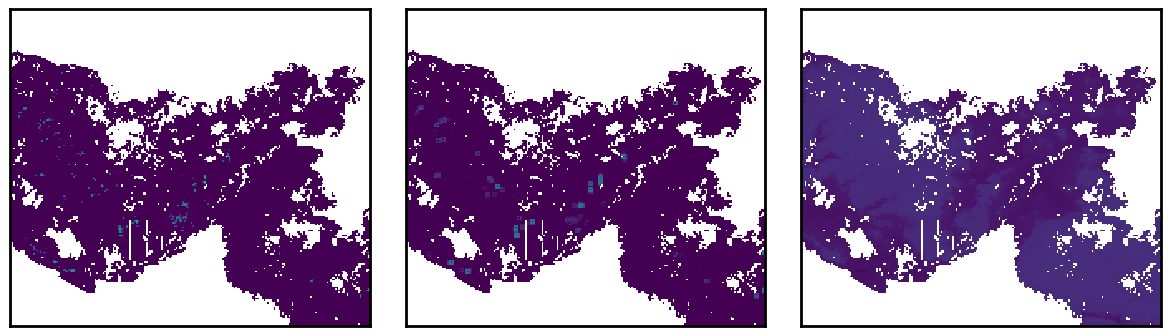

In [80]:
import geopandas as gpd
from matplotlib import colors
from matplotlib.cm import ScalarMappable
regions = gpd.read_file("data_working/figure_overlays.shp")

def make_clipped_plot(geom, **kwargs):
    p = ds23.rio.clip_box(*geom.bounds).plot(
        col="variable", 
        norm=colors.LogNorm(vmin=1e-2, vmax=1), 
        cbar_kwargs=dict(label="Proportion of cell with mortality"),
        xticks=[],
        yticks=[],
        add_labels=False,
        **kwargs
    )
    
    for ax in p.axs.flat:
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")

    return p
    
with plt.rc_context({"font.size":24, "axes.linewidth": 2.0, "grid.linewidth": 2.0}):
    p_top = make_clipped_plot(regions.geometry[2], add_colorbar=False, figsize=(13, 5))

In [65]:
eps = 1e-3
ground_truth = ds_valid.mortality.sel(time=2023).rio.write_crs(3857)/100 + eps

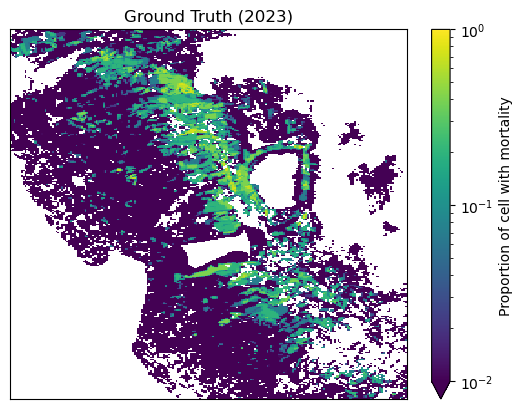

In [66]:
fig, ax = plt.subplots()

ground_truth.rio.clip_box(*regions.geometry[0].bounds).plot(ax=ax, norm=colors.LogNorm(vmin=1e-2, vmax=1), cbar_kwargs=dict(label="Proportion of cell with mortality"))

ax.set_title("Ground Truth (2023)")
ax.set_xticks([])
ax.set_xlabel("")
ax.set_yticks([])
ax.set_ylabel("")
plt.show()

In [57]:
get_results(df_valid["mortality"], df_valid["mort1"])

{'mse': 8.85334300994873, 'nrmse': 3.376289045512368, 'r': 0.2709480330653473}

In [66]:
train_mean_df = ds_train.mean(dim="time")["mortality"].rename("mortality_time_mean").to_dataframe().dropna()

In [68]:
df_valid_join = df_valid.reset_index().set_index(["y", "x"]).join(train_mean_df, on=["y", "x"], how="left")

In [69]:
df_valid_join.head()

time  sample  mortality  mort1  near1  rhost1  \
y           x                                                              
6274802.419 -1.358772e+07  2015       3        0.0    0.0    0.0    75.0   
            -1.358472e+07  2015       4        0.0    0.0    0.0    80.0   
            -1.358372e+07  2015       5        0.0    0.0    0.0    80.0   
            -1.358272e+07  2015       6        0.0    0.0    0.0    78.0   
            -1.358072e+07  2015       7        0.0    0.0    0.0    80.0   

                              prcp_avg  tmin1   prcp1  fire24 stats  \
y           x                                                         
6274802.419 -1.358772e+07  2036.666626   -2.0  1998.0     0.0   max   
            -1.358472e+07  2107.037109   -2.0  2062.0     0.0   max   
            -1.358372e+07  2665.000000   -4.0  2681.0     0.0   max   
            -1.358272e+07  2461.333252   -3.0  2456.0     0.0   max   
            -1.358072e+07  2490.518555   -4.0  2495.0     0.0   max   

                           mortality_time_mean  
y           x                                   
6274802.419 -1.358772e+07                  0.0  
            -1.358472e+07                  0.0  
            -1.358372e+07                  0.0  
            -1.358272e+07                  0.0  
            -1.358072e+07                  0.0

In [72]:
nanmask = ~(df_valid_join["mortality"].isna() | df_valid_join["mortality_time_mean"].isna())
get_results(df_valid_join["mortality"][nanmask], df_valid_join["mortality_time_mean"][nanmask])

{'mse': 6.856245517730713, 'nrmse': 2.613257860080659, 'r': 0.1300453102657216}